Sebastian Raschka, 2015  
`mlxtend`, a library of extension and helper modules for Python's data analysis and machine learning libraries

- GitHub repository: https://github.com/rasbt/mlxtend
- Documentation: http://rasbt.github.io/mlxtend/

View this page in [jupyter nbviewer](http://nbviewer.ipython.org/github/rasbt/mlxtend/blob/master/docs/sources/_ipynb_templates/regressor/linear_regression.ipynb)

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p matplotlib,numpy,scipy,mlxtend

Sebastian Raschka 
last updated: 2016-01-30 

CPython 3.5.1
IPython 4.0.3

matplotlib 1.5.1
numpy 1.10.2
scipy 0.16.1
mlxtend 0.3.0


In [4]:
%matplotlib inline

# Logistic Regression

A logistic regression class for binary classification tasks.

> from mlxtend.classifier import LogisticRegression

# Overview

![](./LogisticRegression_files/logistic_regression_schematic.png)

Related to the [`Perceptron`](./Perceptron.md) and ['Adaline'](./Adaline.md), a Logistic Regression model is a linear model for binary classification. However, instead of minimizing a linear cost function such as the sum of squared errors (SSE) in Adaline, we minimize a sigmoid function, i.e., the logistic function:

$$\phi(z) = \frac{1}{1 + e^{-z}},$$

where $z$ is defined as the net input

$$z = w_0x_0 + w_1x_1 + ... + w_mx_m = \sum_{j=1}^{m} w_j x_j= \mathbf{w}^T\mathbf{x}.$$ 

The net input is in turn based on the logit function

$$logit(p(y=1 \mid \mathbf{x})) = z.$$

Here, $p(y=1 \mid \mathbf{x})$ is the conditional probability that a particular sample belongs to class 1 given its features $\mathbf{x}$. The logit function takes inputs in the range [0, 1] and transform them to values over the entire real number range. In contrast, the logistic function takes input values over the entire real number range and transforms them to values in the range [0, 1]. In other words, the logistic function is the inverse of the logit function, and it lets us predict the conditional probability that a certain sample belongs to class 1 (or class 0).

![](./LogisticRegression_files/logistic_function.png)

After model fitting, the conditional probability $p(y=1 \mid \mathbf{x})$ is converted to a binary class label via a threshold function $g(\cdot)$:

\begin{equation}
 y = g({z}) = \begin{cases}
    1 & \text{if $\phi(z) \ge 0.5$}\\
    0 & \text{otherwise}.
  \end{cases}
\end{equation}

or eqivalently:

\begin{equation}
 y = g({z}) = \begin{cases}
    1 & \text{if z $\ge$ 0}\\
    0 & \text{otherwise}.
  \end{cases}
\end{equation}












### Objective Function -- Log-Likelihood

In order to parameterize a logistic regression model, we maximize the likelihood $L(\cdot)$ (or minimize the logistic cost function).

We write the likelihood as 

$$L(\mathbf{w}) = P(\mathbf{y} \mid \mathbf{x};\mathbf{w}) = \prod_{i=1}^{n} P\big(y^{(i)} \mid x^{(i)}; \mathbf{w}\big) = \prod^{n}_{i=1}\bigg(\phi\big(z^{(i)}\big)\bigg)^{y^{(i)}} \bigg(1-\phi\big(z^{(i)}\big)\bigg)^{1-y^{(i)}},$$

under the assumption that the training samples are independent of each other.

In practice, it is easier to maximize the (natural) log of this equation, which is called
the log-likelihood function:

$$l(\mathbf{w}) = \log L(\mathbf{w}) = \sum^{n}_{i=1} y^{(i)} \log \bigg(\phi\big(z^{(i)}\big)\bigg) + \big( 1 - y^{(i)}\big) \log \big(1-\phi\big(z^{(i)}\big)\big)$$

One advantage of taking the log is to avoid numeric underflow (and challenges with floating point math) for very small likelihoods. Another advantage is that we can obtain the derivative more easily, using the addition trick to rewrite the product of factors as a summation term, which we can then maximize using optimization algorithms such as gradient ascent.

### Objective Function -- Logistic Cost Function

An alternative to maximizing the log-likelihood, we can define a cost function $J(\cdot)$ to be minimized; we rewrite the log-likelihood as:

$$J(\mathbf{w}) = \sum_{i=1}^{m} - y^{(i)} log \bigg( \phi\big(z^{(i)}\big) \bigg) - \big(1 - y^{(i)}\big) log\bigg(1-\phi\big(z^{(i)}\big)\bigg)$$

$$
 J\big(\phi(z), y; \mathbf{w}\big) =\begin{cases}
    -log\big(\phi(z) \big) & \text{if $y = 1$}\\
    -log\big(1- \phi(z) \big) & \text{if $y = 0$}
  \end{cases}
$$

![](./LogisticRegression_files/logistic_cost.png)

As we can see in the figure above, we penalize wrong predictions with an increasingly larger cost.

### Gradient Descent (GD)  and Stochastic Gradient Descent (SGD) Optimization

#### Gradient Ascent and the log-likelihood

To learn the weight coefficient of a logistic regression model via gradient-based optimization, we compute the partial derivative of the log-likelihood function -- w.r.t. the *j*th weight -- as follows:

$$\frac{\partial}{\partial w_j} l(\mathbf{w}) = \bigg(y \frac{1}{\phi(z)} - (1-y) \frac{1}{1-\phi{(z)}} \bigg) \frac{\partial}{\partial w_j}\phi(z)$$

As an intermediate step, we compute the partial derivative of the sigmoid function, which will come in handy later:

\begin{align}
&\frac{\partial}{\partial z} \phi(z) = \frac{\partial}{{\partial z}} \frac{1}{1+e^{-z}} \\\\
&= \frac{1}{(1 + e^{-z})^{2}} e^{-z}\\\\
&= \frac{1}{1+e^{-z}} \bigg(1 - \frac{1}{1+e^{-z}} \bigg)\\\\
&= \phi(z)\big(1-\phi(z)\big)
\end{align}

Now, we re-substitute $$\frac{\partial}{\partial z} \phi(z) = \phi(z) \big(1 - \phi(z)\big)$$ back into in the log-likelihood partial derivative equation and obtain the equation shown below:

\begin{align}
& \bigg(y \frac{1}{\phi{(z)}} - (1 - y) \frac{1}{1 - \phi(z)} \bigg) \frac{\partial}{\partial w_j} \phi(z) \\\\
&= \bigg(y \frac{1}{\phi{(z)}} - (1 - y) \frac{1}{1 - \phi(z)} \bigg) \phi(z) \big(1 - \phi(z)\big) \frac{\partial}{\partial w_j}z\\\\
&= \big(y(1-\phi(z)\big) - (1 - y) \phi(z)\big)x_j\\\\
&=\big(y - \phi(z)\big)x_j
\end{align}

Now, in order to find the weights of the model, we take a step proportional to the positive direction of the gradient to maximize the log-likelihood. Futhermore, we add a coefficient, the learning rate $\eta$ to the weight update:

\begin{align}
& w_j := w_j + \eta \frac{\partial}{\partial w_j} l(\mathbf{w})\\\\
& w_j := w_j + \eta \sum^{n}_{i=1} \big( y^{(i)} - \phi\big(z^{(i)}\big)\big)x_j^{(i)}
\end{align}

Note that the gradient (and weight update) is computed from all samples in the training set in gradient ascent/descent in contrast to stochastic gradient ascent/descent. For more information about the differences between gradient descent and stochastic gradient descent, please see the related article [Gradient Descent and Stochastic Gradient Descent](../general_concepts/gradient-optimization.html).

The previous equation shows the weight update for a single weight $j$. In gradient-based optimization, all weight coefficients are updated simultaneously; the weight update can be written more compactly as 

$$\mathbf{w} := \mathbf{w} + \Delta\mathbf{w},$$
where

$$\Delta{\mathbf{w}} = \eta \nabla l(\mathbf{w})$$

#### Gradient Descent and the logistic cost function

In the previous section, we derived the gradient of the log-likelihood function, which can be optimized via gradient ascent. Similarly, we can obtain the cost gradient of the logistic cost function $J(\cdot)$ and minimize it via gradient descent in order to learn the logistic regression model.

The update rule for a single weight:

\begin{align}
& \Delta{w_j} = -\eta \frac{\partial J}{\partial w_j} \\
& = - \eta \sum_{i=1}^{n}\big(y^{(i)} - \phi\big(z^{(i)}\big) x^{(i)} \big)
\end{align}

The simultaneous weight update:

$$\mathbf{w} := \mathbf{w} + \Delta\mathbf{w}$$

where

$$\Delta{\mathbf{w}} = - \eta \nabla J(\mathbf{w}).$$

#### Shuffling

Random shuffling is implemented as:

- for one or more epochs
    - randomly shuffle samples in the training set
        - for training sample *i*
            - compute gradients and perform weight updates

### Regularization

As a way to tackle overfitting, we can add additional bias to the logistic regression model via a regularization terms. Via the L2 regularization term, we reduce the complexity of the model by penalizing large weight coefficients:



$$L2: \frac{\lambda}{2}\lVert \mathbf{w} \lVert_2 = \frac{\lambda}{2} \sum_{j=1}^{m} w_j^2$$

In order to apply regularization, we just need to add the regularization term to the cost function that we defined for logistic regression to shrink the weights:

$$J(\mathbf{w}) =  \sum_{i=1}^{m} \Bigg[ - y^{(i)} log \bigg( \phi\big(z^{(i)}\big) \bigg) - \big(1 - y^{(i)}\big) log\bigg(1-\phi\big(z^{(i)}\big)\bigg) \Bigg] + \frac{\lambda}{2} \sum_{j=1}^{m} w_j^2$$

The update rule for a single weight:

\begin{align}
& \Delta{w_j} = -\eta \bigg( \frac{\partial J}{\partial w_j} + \lambda w_j\bigg)\\
& = - \eta \sum_{i=1}^{n}\big(y^{(i)} - \phi\big(z^{(i)}\big) x^{(i)} \big) - \eta \lambda w_j
\end{align}

The simultaneous weight update:

$$\mathbf{w} := \mathbf{w} + \Delta\mathbf{w}$$

where

$$\Delta{\mathbf{w}} = - \eta \big( \nabla J(\mathbf{w}) + \lambda \mathbf{w}\big).$$

For more information on regularization, please see [Regularization of Generalized Linear Models](../general_concepts/regularization_linear.md).

### References


- Bishop, Christopher M. [*Pattern recognition and machine learning*](http://www.springer.com/br/book/9780387310732). Springer, 2006. pp. 203-213

### Related Topics

- [classifier.Adaline](./Adaline.md)
- [classifier.Multi-layer Perceptron](./nnet-mlp.md)
- [Gradient Descent and Stochastic Gradient Descent](../general_concepts/gradient-optimization.md)
- [Regularization of Generalized Linear Models](../general_concepts/regularization_linear.md)

# Examples

## Example 1 - Gradient Descent

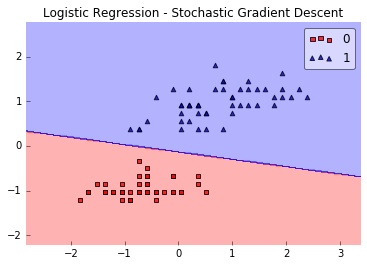

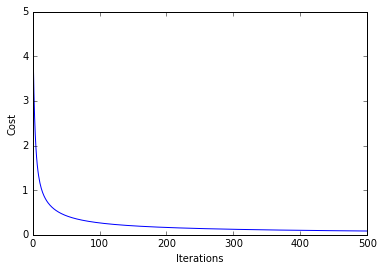

In [5]:
from mlxtend.data import iris_data
from mlxtend.evaluate import plot_decision_regions
from mlxtend.classifier import LogisticRegression
import matplotlib.pyplot as plt

# Loading Data

X, y = iris_data()
X = X[:, [0, 3]] # sepal length and petal width
X = X[0:100] # class 0 and class 1
y = y[0:100] # class 0 and class 1

# standardize
X[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

lr = LogisticRegression(eta=0.1, l2_lambda=0.0, epochs=500, learning='gd', random_seed=1)
lr.fit(X, y)

plot_decision_regions(X, y, clf=lr)
plt.title('Logistic Regression - Stochastic Gradient Descent')
plt.show()

plt.plot(range(len(lr.cost_)), lr.cost_)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

### Predicting Class Labels

In [6]:
y_pred = lr.predict(X)
print('Last 3 Class Labels: %s' % y_pred[-3:])

Last 3 Class Labels: [1 1 1]


In [7]:
y_pred = lr.activation(X)
print('Last 3 Class Labels: %s' % y_pred[-3:])

Last 3 Class Labels: [ 0.99999934  0.99898689  0.99999708]


### Predicting Class Probabilities

## Example 2 - Stochastic Gradient Descent

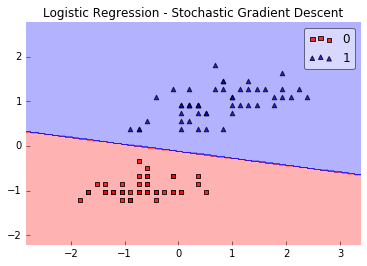

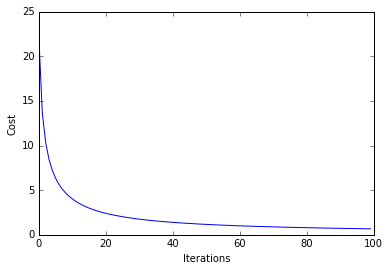

In [8]:
from mlxtend.data import iris_data
from mlxtend.evaluate import plot_decision_regions
from mlxtend.classifier import LogisticRegression
import matplotlib.pyplot as plt

# Loading Data

X, y = iris_data()
X = X[:, [0, 3]] # sepal length and petal width
X = X[0:100] # class 0 and class 1
y = y[0:100] # class 0 and class 1

# standardize
X[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

lr = LogisticRegression(eta=0.05, epochs=100, l2_lambda=0.0, learning='sgd', random_seed=1)
lr.fit(X, y)

plot_decision_regions(X, y, clf=lr)
plt.title('Logistic Regression - Stochastic Gradient Descent')
plt.show()

plt.plot(range(len(lr.cost_)), lr.cost_)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

# API

In [11]:
with open('../../api_modules/mlxtend.classifier/LogisticRegression.md', 'r') as f:
    print(f.read())

## LogisticRegression

*LogisticRegression(eta=0.01, epochs=50, regularization=None, l2_lambda=0.0, learning='sgd', shuffle=False, random_seed=None, zero_init_weight=False)*

Logistic regression classifier.

**Parameters**

- `eta` : float (default: 0.01)

    Learning rate (between 0.0 and 1.0)

- `epochs` : int (default: 50)

    Passes over the training dataset.

- `learning` : str (default: sgd)

    Learning rule, sgd (stochastic gradient descent)
    or gd (gradient descent).

- `regularization` : {None, 'l2'} (default: None)

    Type of regularization. No regularization if
    `regularization=None`.

- `l2_lambda` : float

    Regularization parameter for L2 regularization.
    No regularization if l2_lambda=0.0.

- `shuffle` : bool (default: False)

    Shuffles training data every epoch if True to prevent circles.

- `random_seed` : int (default: None)

    Set random state for shuffling and initializing the weights.

- `zero_init_weight` : bool (default: False)

    If True,